In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
allegations = pd.read_csv('/content/drive/My Drive/NYPD-Misconduct-Complaint-Database/allegations_20200726939.csv')

In [5]:
allegations.head()

,unique_mos_id,first_name,last_name,command_now,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,rank_abbrev_now,rank_now,rank_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,42835,7,2019,5,2020,078 PCT,POM,POM,Police Officer,Police Officer,Hispanic,M,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,24601,11,2011,8,2012,PBBS,POM,POM,Police Officer,Police Officer,White,M,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,24601,11,2011,8,2012,PBBS,POM,POM,Police Officer,Police Officer,White,M,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,26146,7,2012,9,2013,PBBS,POM,POM,Police Officer,Police Officer,White,M,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,40253,8,2018,2,2019,078 PCT,POF,POF,Police Officer,Police Officer,Hispanic,F,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


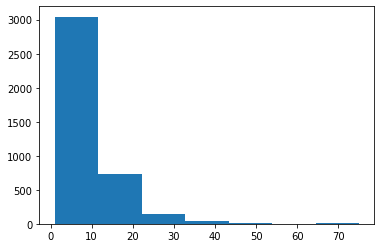

In [6]:
plt.hist([allegations.unique_mos_id.value_counts()], bins = 7)
plt.show()

In [7]:
columns = ['month_received', 'year_received', 'month_closed', 'year_closed', 'rank_incident', 'mos_ethnicity', 'mos_gender', 'mos_age_incident', 'complainant_ethnicity', 'complainant_gender', 'complainant_age_incident', 'fado_type', 'precinct']

In [8]:
ml_data = allegations[columns]

In [9]:
ml_data.head()

,month_received,year_received,month_closed,year_closed,rank_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,precinct
0,7,2019,5,2020,Police Officer,Hispanic,M,32,Black,Female,38.0,Abuse of Authority,78.0
1,11,2011,8,2012,Police Officer,White,M,24,Black,Male,26.0,Discourtesy,67.0
2,11,2011,8,2012,Police Officer,White,M,24,Black,Male,26.0,Offensive Language,67.0
3,7,2012,9,2013,Police Officer,White,M,25,Black,Male,45.0,Abuse of Authority,67.0
4,8,2018,2,2019,Police Officer,Hispanic,F,39,NaN,NaN,16.0,Force,67.0


In [10]:
ml_data.shape

(33358, 13)

In [11]:
ml_data.isnull().sum()

month_received                 0
year_received                  0
month_closed                   0
year_closed                    0
rank_incident                  0
mos_ethnicity                  0
mos_gender                     0
mos_age_incident               0
complainant_ethnicity       4464
complainant_gender          4195
complainant_age_incident    4812
fado_type                      0
precinct                      24
dtype: int64

In [12]:
ml_data = ml_data.dropna()

In [13]:
ml_data.shape

(28299, 13)

In [14]:
ml_data.head()

,month_received,year_received,month_closed,year_closed,rank_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,precinct
0,7,2019,5,2020,Police Officer,Hispanic,M,32,Black,Female,38.0,Abuse of Authority,78.0
1,11,2011,8,2012,Police Officer,White,M,24,Black,Male,26.0,Discourtesy,67.0
2,11,2011,8,2012,Police Officer,White,M,24,Black,Male,26.0,Offensive Language,67.0
3,7,2012,9,2013,Police Officer,White,M,25,Black,Male,45.0,Abuse of Authority,67.0
5,5,2017,10,2017,Sergeant,Black,F,50,White,Male,31.0,Abuse of Authority,78.0


In [15]:
ml_data = ml_data.assign(Total_Months = (ml_data.year_closed - ml_data.year_received) * 12 + (ml_data.month_closed - ml_data.month_received))

In [16]:
ml_data = ml_data.drop(['month_received', 'year_received', 'month_closed', 'year_closed'], axis = 1)

In [17]:
ml_data.head()

,rank_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,precinct,Total_Months
0,Police Officer,Hispanic,M,32,Black,Female,38.0,Abuse of Authority,78.0,10
1,Police Officer,White,M,24,Black,Male,26.0,Discourtesy,67.0,9
2,Police Officer,White,M,24,Black,Male,26.0,Offensive Language,67.0,9
3,Police Officer,White,M,25,Black,Male,45.0,Abuse of Authority,67.0,14
5,Sergeant,Black,F,50,White,Male,31.0,Abuse of Authority,78.0,5


In [18]:
ml_data.dtypes

rank_incident                object
mos_ethnicity                object
mos_gender                   object
mos_age_incident              int64
complainant_ethnicity        object
complainant_gender           object
complainant_age_incident    float64
fado_type                    object
precinct                    float64
Total_Months                  int64
dtype: object

In [19]:
for column in ['rank_incident', 'mos_ethnicity', 'mos_gender', 'complainant_gender', 'complainant_ethnicity', 'fado_type', 'precinct']:
  ml_data[column] = ml_data[column].astype('category')

In [20]:
ml_data['complainant_gender'].value_counts()

Male                     23395
Female                    4844
Not described               33
Transwoman (MTF)            20
Transman (FTM)               5
Gender non-conforming        2
Name: complainant_gender, dtype: int64

In [21]:
ml_data.head()

,rank_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,precinct,Total_Months
0,Police Officer,Hispanic,M,32,Black,Female,38.0,Abuse of Authority,78.0,10
1,Police Officer,White,M,24,Black,Male,26.0,Discourtesy,67.0,9
2,Police Officer,White,M,24,Black,Male,26.0,Offensive Language,67.0,9
3,Police Officer,White,M,25,Black,Male,45.0,Abuse of Authority,67.0,14
5,Sergeant,Black,F,50,White,Male,31.0,Abuse of Authority,78.0,5


In [22]:
ml_data['fado_type'].value_counts()

Abuse of Authority    16837
Force                  6683
Discourtesy            4143
Offensive Language      636
Name: fado_type, dtype: int64

In [23]:
ml_data['complainant_ethnicity'].value_counts()

Black              16882
Hispanic            6332
White               2740
Unknown              830
Other Race           675
Asian                524
Refused              252
American Indian       64
Name: complainant_ethnicity, dtype: int64

In [24]:
ethnicity_mapping = {
    'Black': 0,
    'Asian': 1,
    'Hispanic': 2,
    'White': 3,
    'American Indian': 4,
    'Refused': 5,
    'Other Race': 6,
    'Unknown': 7
}

gender_mapping_complainant = {
    'Male': 0,
    'Female': 1,
    'Not described': 2,
    'Transwoman (MTF)': 3,
    'Transman (FTM)': 4,
    'Gender non-conforming': 5
}

gender_mapping_mos = {
    'M': 0,
    'F': 1
}

rank_mapping = {'Police Officer': 0,
                'Sergeant': 1,
                'Detective': 2,
                'Lieutenant': 3,
                'Captain': 4,
                'Deputy Inspector': 5,
                'Inspector': 6,
                'Chiefs and other ranks': 7
                }

fado_mapping = {
    'Abuse of Authority': 0,
    'Force': 1,
    'Discourtesy': 2,
    'Offensive Language': 3
}

In [25]:
ml_data['complainant_ethnicity'] = ml_data['complainant_ethnicity'].map(ethnicity_mapping)
ml_data['complainant_gender'] = ml_data['complainant_gender'].map(gender_mapping_complainant)
ml_data['fado_type'] = ml_data['fado_type'].map(fado_mapping)
ml_data['rank_incident'] = ml_data['rank_incident'].map(rank_mapping)
ml_data['mos_ethnicity'] = ml_data['mos_ethnicity'].map(ethnicity_mapping)
ml_data['mos_gender'] = ml_data['mos_gender'].map(gender_mapping_mos)

In [26]:
ml_data.head()

,rank_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,precinct,Total_Months
0,0,2,0,32,0,1,38.0,0,78.0,10
1,0,3,0,24,0,0,26.0,2,67.0,9
2,0,3,0,24,0,0,26.0,3,67.0,9
3,0,3,0,25,0,0,45.0,0,67.0,14
5,1,0,1,50,3,0,31.0,0,78.0,5


In [27]:
ml_data.dtypes

rank_incident               category
mos_ethnicity               category
mos_gender                  category
mos_age_incident               int64
complainant_ethnicity       category
complainant_gender          category
complainant_age_incident     float64
fado_type                   category
precinct                    category
Total_Months                   int64
dtype: object

In [28]:
ml_data['complainant_gender'] = ml_data['complainant_gender'].astype(int)

In [29]:
ml_data.head()

,rank_incident,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,precinct,Total_Months
0,0,2,0,32,0,1,38.0,0,78.0,10
1,0,3,0,24,0,0,26.0,2,67.0,9
2,0,3,0,24,0,0,26.0,3,67.0,9
3,0,3,0,25,0,0,45.0,0,67.0,14
5,1,0,1,50,3,0,31.0,0,78.0,5


In [30]:
ml_data['precinct'].value_counts()

75.0      1784
73.0      1001
44.0       991
79.0       950
46.0       942
          ... 
17.0        70
111.0       31
22.0        12
1000.0       3
0.0          2
Name: precinct, Length: 79, dtype: int64

In [51]:
import lightgbm as lgb
from lightgbm import *

In [32]:
X = ml_data.drop(['Total_Months'], axis=1)
Y = ml_data['Total_Months']

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True)

In [36]:
scaler = StandardScaler()

In [37]:
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

Y_train = pd.DataFrame(np.log(Y_train))
Y_test = pd.DataFrame(np.log(Y_test))

In [38]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train)

In [39]:
reg = lgb.LGBMRegressor(reg_lambda=1.0, random_state=0)

In [40]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'verbose': 1,
    'reg_lambda': 1.0,
    'random_state': 0}

In [41]:
print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

Starting training...
[1]	valid_0's l2: 0.233475	valid_0's l1: 0.397114
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.231863	valid_0's l1: 0.395715
[3]	valid_0's l2: 0.230417	valid_0's l1: 0.394591
[4]	valid_0's l2: 0.229126	valid_0's l1: 0.393406
[5]	valid_0's l2: 0.228093	valid_0's l1: 0.392475
[6]	valid_0's l2: 0.227074	valid_0's l1: 0.391527
[7]	valid_0's l2: 0.226013	valid_0's l1: 0.390666
[8]	valid_0's l2: 0.225174	valid_0's l1: 0.389914
[9]	valid_0's l2: 0.224505	valid_0's l1: 0.389326
[10]	valid_0's l2: 0.223878	valid_0's l1: 0.388753
[11]	valid_0's l2: 0.223261	valid_0's l1: 0.388181
[12]	valid_0's l2: 0.222521	valid_0's l1: 0.387499
[13]	valid_0's l2: 0.221938	valid_0's l1: 0.38695
[14]	valid_0's l2: 0.221346	valid_0's l1: 0.386388
[15]	valid_0's l2: 0.220594	valid_0's l1: 0.385685
[16]	valid_0's l2: 0.219877	valid_0's l1: 0.384925
[17]	valid_0's l2: 0.219342	valid_0's l1: 0.384537
[18]	valid_0's l2: 0.218759	valid_0's l1: 0.383987
[19]	valid

In [42]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [43]:
print('The rmse of prediction is:', mean_squared_error(Y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.46684959782850444


In [58]:
fn = 'model.txt'
lgb.Booster.save_model(filename=fn)

TypeError: ignored

In [76]:
gbm.save_model('lgb_classifier.txt', num_iteration=gbm.best_iteration)